# <center>Problema de Kantorovich</center>

In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import linprog
import scipy.stats as sps
import ot

np.random.seed(42)

## Problema discreto

### Generación de datos

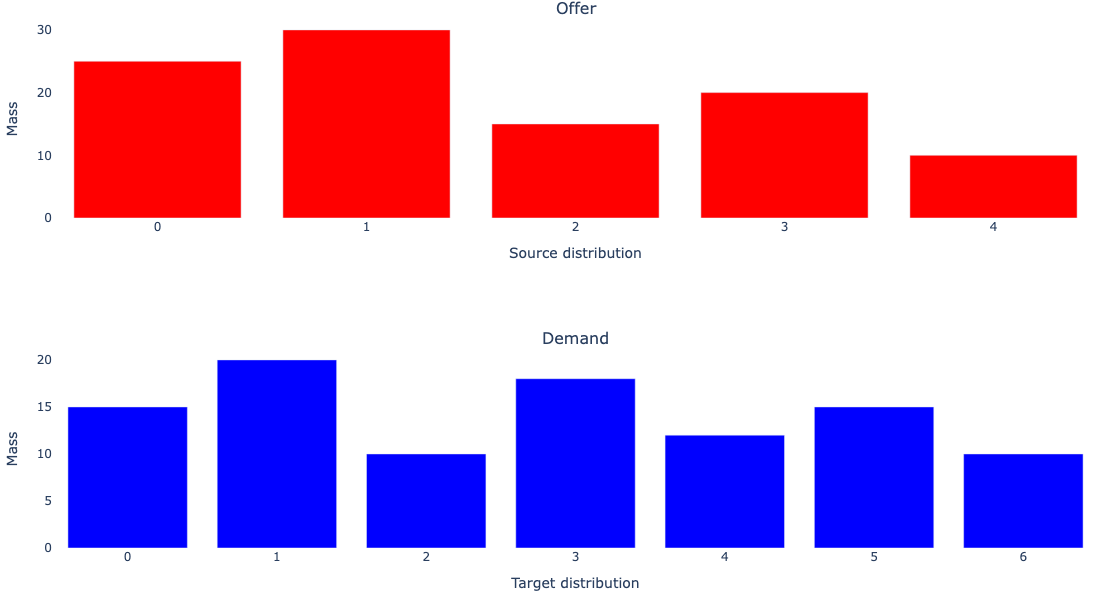

In [25]:
# Distribución de origen y llegada:
x = np.array([25, 30, 15, 20, 10], dtype=float)
y = np.array([15, 20, 10, 18, 12, 15, 10], dtype=float)

# Matriz de costo:
C = np.array([
    [4, 7, 3, 6, 2, 5, 8],
    [6, 3, 8, 2, 5, 1, 4],
    [2, 5, 1, 7, 3, 6, 9],
    [5, 8, 4, 1, 6, 3, 7],
    [3, 6, 9, 4, 7, 2, 5]
], dtype=float)

# Histogramas de oferta y demanda:
n_points_x, n_points_y = len(x), len(y)
fig = make_subplots(rows=2, cols=1, subplot_titles=('Offer', 'Demand'))
fig.add_trace(go.Bar(x=list(range(n_points_x)), y=x, marker_color='red'), row=1, col=1)
fig.add_trace(go.Bar(x=list(range(n_points_y)), y=y, marker_color='blue'), row=2, col=1)

# Configuraciones gráficas:
fig.update_xaxes(title_text='Source distribution', row=1, col=1)
fig.update_xaxes(title_text='Target distribution', row=2, col=1)
fig.update_yaxes(title_text='Mass', row=1, col=1)
fig.update_yaxes(title_text='Mass', row=2, col=1)
fig.update_layout(height=600, width=300, showlegend=False, plot_bgcolor='white', paper_bgcolor='white')

fig.update_layout( margin=dict(l=20, r=20, t=20, b=20) ) 
fig.show()
fig.write_image('../img/kantorovich_discrete_histogram.pdf')

### Transporte óptimo

#### Matriz solución

In [26]:
def discrete_kantorovich(x, y, C):
    assert x.sum() == y.sum(), 'La masa total no coincide.'
    n_points_x, n_points_y = len(x), len(y)
    # Matriz del problema lineal:
    Ax = np.kron(np.identity(n_points_x), np.ones(n_points_y))
    Ay = np.kron(np.ones(n_points_x), np.identity(n_points_y))
    A = np.concatenate((Ax, Ay), 0)
    # Vector del problema lineal:
    b = np.concatenate([x, y])
    # Optimización:
    res = linprog(C.flatten(), A_eq=A, b_eq=b)
    P = res.x.reshape([n_points_x, n_points_y])
    
    # Gráfico solución:
    fig = make_subplots(
        rows=2, cols=2, 
        column_widths=[0.15, 0.85], 
        row_heights=[0.15, 0.85],
        horizontal_spacing=0.01,
        vertical_spacing=0.01,
        specs=[[None, {"type": "bar"}], 
               [{"type": "bar"}, {"type": "heatmap"}]]
    )
    
    fig.add_trace(go.Bar(y=list(range(n_points_x)), x=x, orientation='h', marker_color='red', opacity=0.8), row=2, col=1)
    fig.add_trace(go.Bar(x=list(range(n_points_y)), y=y, marker_color='blue', opacity=0.8), row=1, col=2)
    
    heatmap_text = [[str(int(P[i,j])) if P[i,j] > 0 else '0' for j in range(n_points_y)] for i in range(n_points_x)]
    fig.add_trace(go.Heatmap(z=P, text=heatmap_text, texttemplate="%{text}", showscale=False), row=2, col=2)
    
    # Configuraciones gráficas:
    fig.update_xaxes(showticklabels=False, showgrid=False)
    fig.update_yaxes(showticklabels=False, showgrid=False)
    
    fig.update_layout(
        height=600, 
        width=600, 
        showlegend=False, 
        plot_bgcolor='white', 
        paper_bgcolor='white',
        margin=dict(l=20, r=20, t=20, b=20)
    )
    
    fig.update_xaxes(range=[max(x), 0], row=2, col=1)
    fig.update_yaxes(range=[-0.5, n_points_x-0.5], row=2, col=1)
    fig.update_xaxes(range=[-0.5, n_points_y-0.5], row=1, col=2)
    fig.update_yaxes(range=[0, max(y)], row=1, col=2)

    fig.update_layout( margin=dict(l=20, r=20, t=20, b=20) ) 
    fig.show()
    fig.write_image('../img/kantorovich_discrete_solution.pdf')

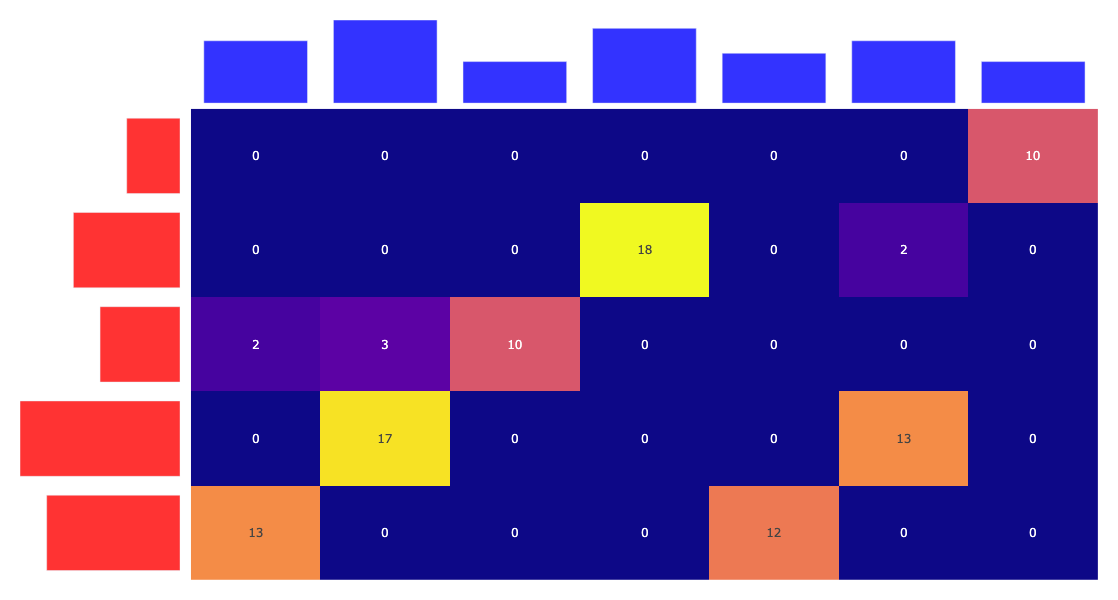

In [27]:
discrete_kantorovich(x, y, C)

## Problema continuo

### Generación de datos

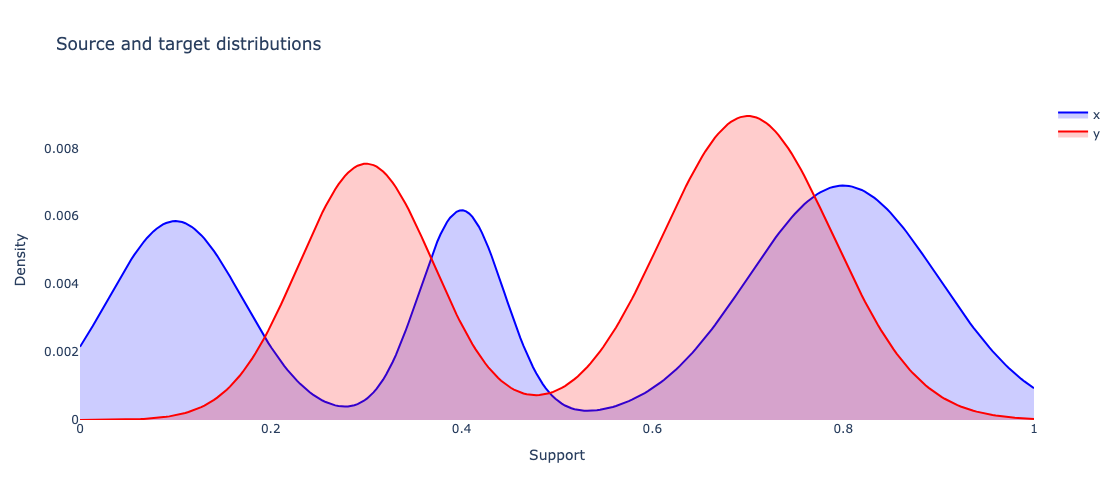

In [15]:
def generate_mixture(alpha, mu, var, interval=[0,1], n=300):

    mixture_size = len(alpha)
    t = np.linspace(*interval, num=n)

    density = 0
    for j in range(mixture_size):
        density += alpha[j] * sps.norm.pdf(t, loc=mu[j], scale=np.sqrt(var[j]))
    
    density /= density.sum()
    return density

# Mixturas:
gmm_x = generate_mixture([0.3, 0.2, 0.5], [0.1, 0.4, 0.8], [0.005, 0.002, 0.01])
gmm_y = generate_mixture([0.4, 0.6], [0.3, 0.7], [0.005, 0.008])

# Visualización de densidades:
fig = go.Figure()
t = np.linspace(0, 1, num=len(gmm_x))
fig.add_trace(go.Scatter(x=t, y=gmm_x, fill='tozeroy', fillcolor='rgba(0,0,255,0.2)', line_color='blue', name='x'))
fig.add_trace(go.Scatter(x=t, y=gmm_y, fill='tozeroy', fillcolor='rgba(255,0,0,0.2)', line_color='red', name='y'))

fig.update_layout(
    title='Source and target distributions',
    xaxis_title='Support',
    yaxis_title='Density',
    height=500, width=1200,
    plot_bgcolor='white', paper_bgcolor='white')

fig.show()
fig.write_image('../img/kantorovich_continuous_density.pdf')

### Transporte óptimo

In [16]:
def continuous_kantorovich(x, y):
    assert len(x) == len(y), 'Las densidades deben tener la misma longitud.'
    n_points = len(x)

    # Optimización:
    t = np.linspace(0, 1, num=n_points)
    M = ot.dist(t[:, np.newaxis], t[:, np.newaxis])
    P = ot.emd(x, y, M)

    # Gráfico solución:
    fig = make_subplots(rows=2, cols=2, column_widths=[0.15, 0.85], row_heights=[0.15, 0.85],
                        horizontal_spacing=0.01, vertical_spacing=0.01,
                        specs=[[None, {"type": "scatter"}], [{"type": "scatter"}, {"type": "heatmap"}]])
    fig.add_trace(go.Scatter(x=x, y=t, mode='lines', line=dict(color='red', width=1), fill='tozerox', fillcolor='rgba(255,0,0,0.1)'), row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=y, mode='lines', line=dict(color='blue', width=1), fill='tozeroy', fillcolor='rgba(0,0,255,0.1)'), row=1, col=2)
    fig.add_trace(go.Heatmap(z=P, colorscale='Viridis', showscale=False), row=2, col=2)
    
    # Configuraciones gráficas:
    fig.update_xaxes(showticklabels=False, showgrid=False, range=[max(x), 0], row=2, col=1)
    fig.update_yaxes(showticklabels=False, showgrid=False, range=[0, 1], row=2, col=1)
    fig.update_xaxes(showticklabels=False, showgrid=False, range=[0, 1], row=1, col=2)
    fig.update_yaxes(showticklabels=False, showgrid=False, range=[0, max(y)], row=1, col=2)
    fig.update_xaxes(showticklabels=False, showgrid=False, row=2, col=2)
    fig.update_yaxes(showticklabels=False, showgrid=False, row=2, col=2)
    fig.update_layout(height=700, width=700, showlegend=False, plot_bgcolor='white', paper_bgcolor='white',
                      margin=dict(l=20, r=20, t=20, b=20))
    fig.show()
    fig.write_image('../img/kantorovich_continuous_solution.pdf')

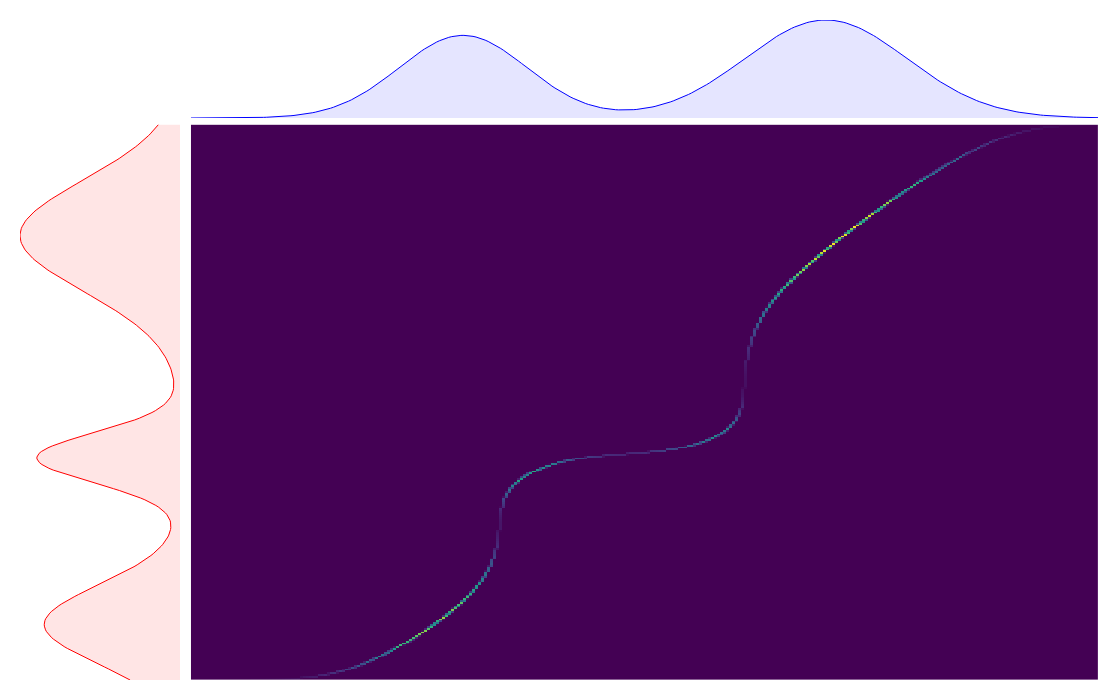

In [17]:
continuous_kantorovich(gmm_x, gmm_y)